In [10]:
import pandas as pd
import sqlite3

In [11]:
conn = sqlite3.connect('../dataset/checking-logs.sqlite')
conn

<h2>Анализируйте только пользователей, а не администраторов</h2>

In [12]:
query = """
SELECT
    uid, timestamp
FROM 
    checker
WHERE 
    uid LIKE 'user_%'
"""

commit = pd.io.sql.read_sql(query, conn, parse_dates='timestamp')
commit

,uid,timestamp
0,user_4,2020-04-17 05:19:02.744528
1,user_4,2020-04-17 05:22:35.249331
2,user_4,2020-04-17 05:22:45.549397
3,user_4,2020-04-17 05:34:14.691200
4,user_4,2020-04-17 05:34:24.422370
...,...,...
3202,user_1,2020-05-21 20:19:06.872761
3203,user_1,2020-05-21 20:22:41.785725
3204,user_1,2020-05-21 20:22:41.877806
3205,user_1,2020-05-21 20:37:00.129678


<h2>Для каждого часа рассчитайте среднее количество коммитов в рабочие дни и в выходные (если за час не было коммитов, не используйте его для расчёта среднего значения) и используйте эти значения для построения графика, например: понедельник, 17:00–18:00: 5 коммитов, вторник, 17:00–18:00: 6 коммитов, среда, 17:00–18:00: 7 коммитов</h2>

In [13]:
commit['weekday'] = commit['timestamp'].dt.dayofweek
commit['day'] = commit.timestamp.dt.day
commit['hour'] = commit.timestamp.dt.hour
commit['type'] = commit['weekday'].apply(lambda x: 'Work' if x < 5 else 'Weekend')
commit = commit.drop(columns = 'weekday')
commit

,uid,timestamp,day,hour,type
0,user_4,2020-04-17 05:19:02.744528,17,5,Work
1,user_4,2020-04-17 05:22:35.249331,17,5,Work
2,user_4,2020-04-17 05:22:45.549397,17,5,Work
3,user_4,2020-04-17 05:34:14.691200,17,5,Work
4,user_4,2020-04-17 05:34:24.422370,17,5,Work
...,...,...,...,...,...
3202,user_1,2020-05-21 20:19:06.872761,21,20,Work
3203,user_1,2020-05-21 20:22:41.785725,21,20,Work
3204,user_1,2020-05-21 20:22:41.877806,21,20,Work
3205,user_1,2020-05-21 20:37:00.129678,21,20,Work


In [14]:
commits_groupped = commit.groupby(['type', 'day', 'hour']).count()
commits_groupped = commits_groupped.groupby(['type', 'hour']).mean()['uid'].reset_index()
commits_groupped

,type,hour,uid
0,Weekend,0,2.000000
1,Weekend,1,6.000000
2,Weekend,3,1.000000
3,Weekend,5,2.000000
4,Weekend,7,4.000000
5,Weekend,8,7.000000
6,Weekend,9,3.666667
7,Weekend,10,7.000000
8,Weekend,11,23.600000
9,Weekend,12,9.500000


In [15]:
pivot_table = pd.pivot(commits_groupped, values='uid', index='hour',columns='type')
pivot_table

type,Weekend,Work
hour,,
0,2.000000,3.000000
1,6.000000,NaN
3,1.000000,2.000000
5,2.000000,7.500000
6,NaN,1.500000
7,4.000000,5.166667
8,7.000000,3.700000
9,3.666667,6.000000
10,7.000000,13.200000


array([<Axes: title={'center': 'Weekend'}, xlabel='hour'>,
       <Axes: title={'center': 'Work'}, xlabel='hour'>], dtype=object)

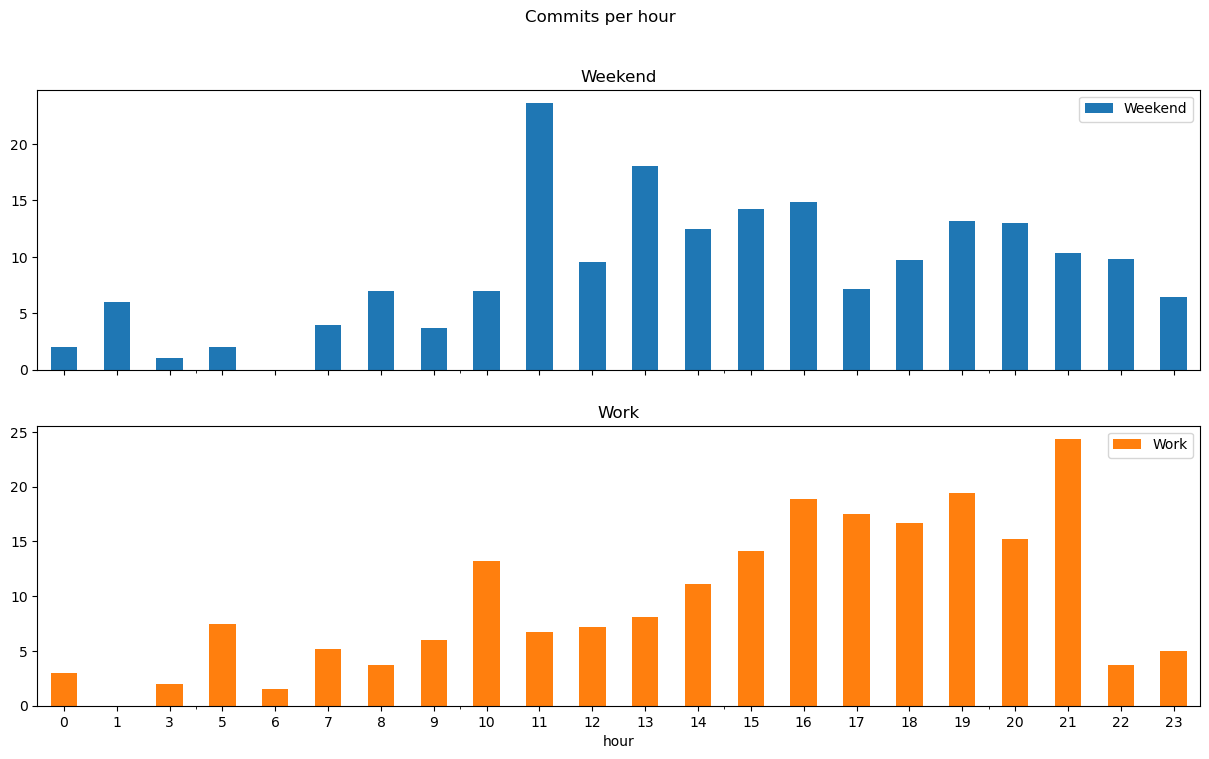

In [16]:
pivot_table.plot(kind = 'bar', title = 'Commits per hour', figsize=(15,8), rot = 0, subplots = True)

<h2>«Отличается ли динамика в рабочие дни и выходные?» Для ответа укажите час, когда количество коммитов наибольшее в рабочие дни, и час, когда оно наибольшее в выходные.</h2>

В будний день наибольшее число коммитов в 21:00

In [17]:
work_max = pivot_table[pivot_table['Work'] == pivot_table['Work'].max()]
work_max

type,Weekend,Work
hour,,
21,10.285714,24.333333


В выходной день наибольшее число коммитов в 11 часов

In [18]:
week_max = pivot_table[pivot_table['Weekend'] == pivot_table['Weekend'].max()]
week_max

type,Weekend,Work
hour,,
11,23.6,6.769231


<h2>ВЫВОД: динамика отличается, в выходной день пользователи активнее утром, а в рабочий вечером</h2>